In [1]:
from support import *

import numpy as np

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry
from photutils.psf import CircularGaussianPRF

import matplotlib.pyplot as plt

from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord

from astropy.coordinates import Angle
import astropy.units as u

import pandas as pd

In [2]:
fname = ['R2048554P.fit']
# Read fits
ffile = fits.open(f'C:\\Users\\lrikozavr\\work\\LAO\\2024_04_27\\LEO_Meade902\\N18340\\{fname[0]}')
data = ffile[0].data.transpose()
head = ffile[0].header

In [106]:
head

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  480                                                  
NAXIS2  =                  640                                                  
EXTEND  =                    T                                                  
BSCALE  =                    1                                                  
BZERO   =                32768                                                  
DATE-OBS= '2024-11-25'                                                          
TIME-OBS= '15:45:03.324009'                                                     
RA-C    = '02h47m13.53072172s'                                                  
DEC-C   = '+10d54m30.06611068s'                                                 
AZ-C    = '+92d51m48.6090087

In [4]:
#Координати центру
coord = SkyCoord(f'{head["RA"]} {head["DEC"]}', 
                 unit=("hourangle","deg"), 
                 frame="icrs", 
                 obstime=f'{head["DATE-OBS"]}T{head["TIME-OBS"]}'
)
#Кидаємо запит до Vizier, щоб витягнути зірки з каталогу Tycho2, які мають яскравість менше 6 mag
TYCHO2 = Vizier(catalog="I/350/tyc2tdsc")
# Критерій який скидує ліміт на кількість зірок 
TYCHO2.ROW_LIMIT = -1
# 
result = TYCHO2.query_region(coordinates=coord,
                          width=6*u.deg,height=6*u.deg,
                          column_filters={'BTmag': '<12'})


In [5]:
result[0]

IDTyc2,RAT,DET,pmRA,pmDE,EpRA1990,EpDE1990,CCDM,BTmag,VTmag,TDSC,WDS,PA,Sep,_RA.icrs,_DE.icrs
,deg,deg,mas / yr,mas / yr,yr,yr,,mag,mag,,,deg,arcsec,deg,deg
str14,float64,float64,float32,float32,float32,float32,str4,float32,float32,int32,str12,float32,float32,float64,float64
2646-9-1,282.38897222000,34.21490694000,10.7,-24.1,1.60,1.60,,11.413,10.534,--,,--,--,282.38900816264,34.21483999555
2646-54-1,282.72501056000,34.22244056000,8.6,3.9,1.59,1.56,,10.043,9.672,--,,--,--,282.72503945108,34.22245139333
2646-129-1,282.36254528000,34.19378639000,-0.5,-7.6,1.57,1.59,,11.930,11.508,--,,--,--,282.36254360086,34.19376527889
2646-137-1,282.85241861000,34.41506361000,3.5,-0.6,1.48,1.58,,10.713,9.467,--,,--,--,282.85243039501,34.41506194333
2646-183-1,282.91592583000,34.40180583000,7.8,-15.2,1.56,1.54,,10.994,10.580,--,,--,--,282.91595208957,34.40176360777
2646-211-1,282.38988278000,34.25473028000,7.2,-7.5,1.51,1.64,,8.189,8.078,48784,18496+3415,--,--,282.38990697715,34.25470944666
2646-239-1,282.75509250000,34.39389917000,13.9,3.6,1.51,1.57,,7.392,7.168,--,,--,--,282.75513929150,34.39390916999
2646-263-1,282.41620583000,34.38592778000,21.8,30.9,1.50,1.59,,10.951,10.292,--,,--,--,282.41627920831,34.38601361331


In [5]:
#Витягуємо значення координат 
radec = np.deg2rad(np.array([[result[0]["RAT"][i], result[0]["DET"][i]] for i in range(len(result[0]))]))

In [35]:
fi = np.deg2rad(49.917611730650556)
center_A = Angle(f'{head["AZ-C"]}').to_value(u.rad)
center_h = Angle(f'{head["ALT-C"]}').to_value(u.rad)
center_hour_angle, center_declination = horizontal_to_equatorial(center_A,center_h,fi)

In [6]:
# Витягуємо з хедера локальний зоряний час
local_siderial_time = Angle(f'{head["TIME-SID"]} hours').to_value(u.rad)
# Координати центру кадру (принаймні, так думає система)
RA = Angle(f'{head["RA"]} hours').to_value(u.rad)
DEC = Angle(f'{head["DEC"]} deg').to_value(u.rad)

#RA = Angle(f'19:09:08.62924 hours').to_value(u.rad)
#DEC = Angle(f'+37:53:16.2397 deg').to_value(u.rad)
# Перехід від RA до часового куту
center_hour_angle = hour_ra_(RA,local_siderial_time)
center_declination = DEC

# 
fi = np.deg2rad(49.917611730650556)
center_A, center_h = equatorial_to_horizontal(center_hour_angle,center_declination,fi)

# Матриця повороту, яка повертає декартову систему так, щоб вісь Z була нормаллю до площини кадру
# Обчислюється як множення інших матриць повороту на основі координат кочки на сфері
rotation_matrix = matrix(-(np.pi/2.-center_h),"y") @ (
                            matrix(-center_A,"z") @ matrix(-(np.pi/2.-fi),"y"))

In [7]:
xyz = pd.DataFrame(columns=["x","y","z"])
for i in radec:
    # Перехід зі сферичної до декартової системи координат з множенням на матрицю повороту
    xyz = pd.concat([xyz,pd.DataFrame([rotation_matrix @ np.array(spherical_to_cartesian(1,hour_ra_(i[0],local_siderial_time),np.pi/2. - i[1]))],columns=["x","y","z"])])
    
# Перехід від декартової сист. коорд. до координат площини кадру
X,Y = cartesian_to_plane(xyz["x"].values,xyz["y"].values,naxis = (head["NAXIS1"],head["NAXIS2"]), fov=np.deg2rad((3,4)), orientation=(1,1))

C:\Users\lrikozavr\AppData\Local\Temp\ipykernel_12328\1913023683.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  xyz = pd.concat([xyz,pd.DataFrame([rotation_matrix @ np.array(spherical_to_cartesian(1,hour_ra_(i[0],local_siderial_time),np.pi/2. - i[1]))],columns=["x","y","z"])])


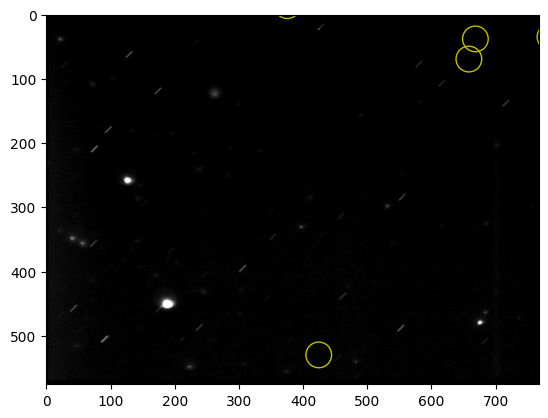

In [104]:
# формування списку координат для побудови зображення
xy = [[Y[i], X[i]] for i in range(len(X))]
# Draw data
plt.imshow(data, vmin=np.median(data), vmax=3 * np.median(data), cmap="Greys_r")
_ = CircularAperture(xy, r=20.0).plot(color="y")
#plt.colorbar()
plt.show()

<h1>Все разом</h1>

In [133]:
#%%timeit
fname = ['R2048554P.fit']
# Read fits
ffile = fits.open(f'C:\\Users\\lrikozavr\\work\\LAO\\2024_04_27\\LEO_Meade902\\N18340\\{fname[0]}')
data = ffile[0].data.transpose()
head = ffile[0].header
#Координати центру
coord = SkyCoord(f'{head["RA"]} {head["DEC"]}', 
                 unit=("hourangle","deg"), 
                 frame="icrs", 
                 obstime=f'{head["DATE-OBS"]}T{head["TIME-OBS"]}'
)
#Кидаємо запит до Vizier, щоб витягнути зірки з каталогу Tycho2, які мають яскравість менше 6 mag
TYCHO2 = Vizier(catalog="I/350/tyc2tdsc")
# Критерій який скидує ліміт на кількість зірок 
TYCHO2.ROW_LIMIT = -1
# 
result = TYCHO2.query_region(coordinates=coord,
                          width=8*u.deg,height=6*u.deg,
                          column_filters={'BTmag': '<7'})
#Витягуємо значення координат 
radec = np.deg2rad(np.array([[result[0]["RAT"][i], result[0]["DET"][i]] for i in range(len(result[0]))]))
# Витягуємо з хедера локальний зоряний час
local_siderial_time = Angle(f'{head["TIME-SID"]} hours').to_value(u.rad)
# Координати центру кадру (принаймні, так думає система)
RA = Angle(f'{head["RA"]} hours').to_value(u.rad)
DEC = Angle(f'{head["DEC"]} deg').to_value(u.rad)

#RA = Angle(f'19:09:08.62924 hours').to_value(u.rad)
#DEC = Angle(f'+37:53:16.2397 deg').to_value(u.rad)
# Перехід від RA до часового куту
center_hour_angle = hour_ra_(RA,local_siderial_time)
center_declination = DEC

# 
fi = np.deg2rad(49.917611730650556)
center_A, center_h = equatorial_to_horizontal(center_hour_angle,center_declination,fi)

# Матриця повороту, яка повертає декартову систему так, щоб вісь Z була нормаллю до площини кадру
# Обчислюється як множення інших матриць повороту на основі координат кочки на сфері
rotation_matrix = matrix(-(np.pi/2.-center_h),"y") @ (
                            matrix(-center_A,"z") @ matrix(-(np.pi/2.-fi),"y"))
xyz = pd.DataFrame(columns=["x","y","z"])
for i in radec:
    # Перехід зі сферичної до декартової системи координат з множенням на матрицю повороту
    xyz = pd.concat([xyz,pd.DataFrame([rotation_matrix @ np.array(spherical_to_cartesian(1,hour_ra_(i[0],local_siderial_time),np.pi/2. - i[1]))],columns=["x","y","z"])])
    
# Перехід від декартової сист. коорд. до координат площини кадру
X,Y = cartesian_to_plane(xyz["x"].values,xyz["y"].values,naxis = (head["NAXIS1"],head["NAXIS2"]), fov=np.deg2rad((3,4)), orientation=(1,1))

C:\Users\lrikozavr\AppData\Local\Temp\ipykernel_4024\4053430612.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  xyz = pd.concat([xyz,pd.DataFrame([rotation_matrix @ np.array(spherical_to_cartesian(1,hour_ra_(i[0],local_siderial_time),np.pi/2. - i[1]))],columns=["x","y","z"])])


In [142]:
mean, median, std = sigma_clipped_stats(data, sigma=3)
threshold = median + (3. * std)
print(mean, median, std, threshold)
# Detect sources
# https://photutils.readthedocs.io/en/2.0.0/user_guide/psf.html
# maybe should pay attention to http://www.aspylib.com/
FWHM = 5.
R = int(FWHM*4) // 2 + 1
psf_model = CircularGaussianPRF(flux=mean*3, fwhm=FWHM)
fit_shape = (R, R)
#finder = DAOStarFinder(std*6, FWHM)
finder = DAOStarFinder(mean, FWHM)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                        aperture_radius=R)
phot = psfphot(data)
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')])

3081.753223692357 3095.0 100.99691763487876 3397.9907529046363
 id       x_fit              y_fit            flux_fit    
--- ------------------ ----------------- -----------------
  1 126.36263896483598 258.5974794562857 672394.4402902348
  2 40.327926368607805 348.7907742291375 266279.0017662867
  3 188.34918024527582 451.4870062819441 923895.1199243837
  4  675.4456704750648 479.8733793396235 465715.6998789255
  5  3.707609916873066 570.4176834043019 162244.8691150231


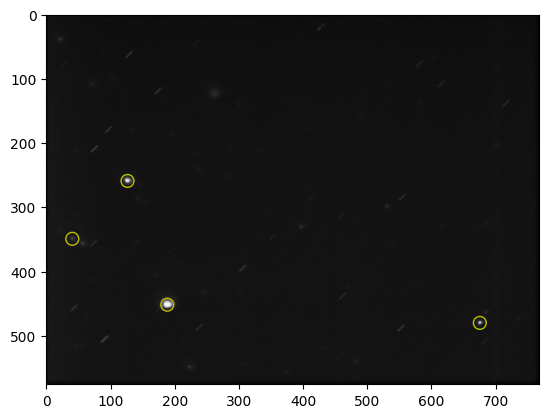

In [137]:
xy_1 = [[rec['x_fit'], rec['y_fit']] for rec in phot if rec["flags"] == 0]

# Draw data
plt.imshow(data, cmap="Greys_r")
_ = CircularAperture(xy_1, r=10.0).plot(color="y")
#plt.colorbar()
plt.show()

In [138]:
xy_2 = np.array([[Y[i],X[i]] for i in range(len(X))])

<h2>Шукаємо відповідники</h2>

In [143]:
xy_test = one(xy_1,xy_2,4,gap_value = 1,accuracy=[0,0], aperture=[45,0.2])
xy_test

array([12, -1, 13,  4])

<h2>Шукаємо усереднине значення зсуву</h2>

In [145]:
m = np.zeros((len(xy_test),2))
j = 0
mean = 0
for i in range(len(xy_test)):
    if(xy_test[i] == -1):
        continue
    j+=1
    m[i,:] = xy_1[i] - xy_2[xy_test[i]]
    mean += m[i,:]
#m, np.delete(m,np.argwhere(m == 0))
vector = mean/j
vector


array([274.08327611, -38.26621922])

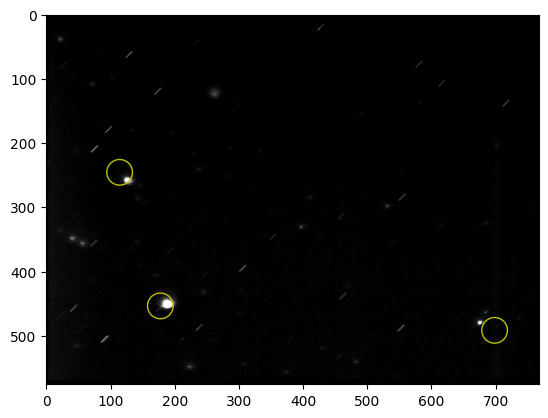

In [146]:
# формування списку координат для побудови зображення
xy = [[Y[i]+vector[0], X[i]+vector[1]] for i in range(len(X))]
# Draw data
plt.imshow(data, vmin=np.median(data), vmax=3 * np.median(data), cmap="Greys_r")
_ = CircularAperture(xy, r=20.0).plot(color="y")
#plt.colorbar()
plt.show()

<h1>Поворот зображення</h1>

In [73]:
#Для визначення куту повороту ми скористуємося цим співідношенням
r_matrix =  matrix(-(np.pi/2.-center_declination),"y") @ (
            matrix(-center_hour_angle,"z") @ (
            matrix(-(np.pi/2.-fi),"y").transpose() @ (
            matrix(-center_A,"z").transpose() @ matrix(-(np.pi/2.-center_h),"y").transpose())))
# Щоб дізнатися кут ми беремо arccos
rot_angle = np.acos(r_matrix[0,0])

In [74]:
# множимо отримані данні на матрицю повороту
r_xyz = pd.DataFrame((matrix(-rot_angle,"z") @ xyz.values.transpose()).transpose(),columns=["x","y","z"])
# Переводимо їх у площину кадру
r_X, r_Y = cartesian_to_plane(r_xyz["x"].values,r_xyz["y"].values,
                             naxis = (head["NAXIS1"],head["NAXIS2"]),
                             fov=np.deg2rad((3,4)), 
                             orientation=(1,1))

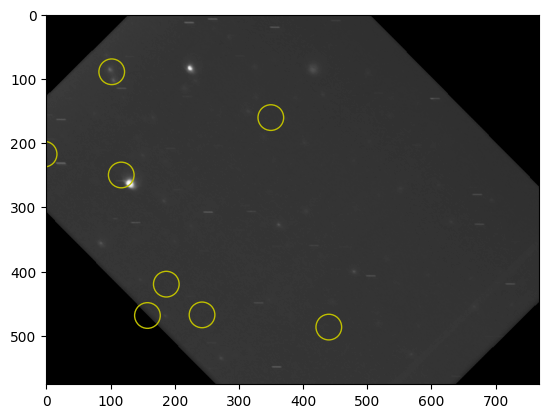

In [86]:
from scipy import ndimage
from astropy.coordinates import Angle

r_xy = [[r_Y[i]+200, r_X[i]] for i in range(len(X))]
# Повертаємо зображення
rotated = ndimage.rotate(data,-np.rad2deg(np.acos(7.01617457e-01)),reshape=False)
plt.imshow(rotated, cmap="Greys_r")
_ = CircularAperture(r_xy, r=20.0).plot(color="y")


In [204]:
xy_1 = [[Y[i], X[i]] for i in range(len(X))]
xy_2 = [[Y[i]+100, X[i]+50] for i in range(len(X))]

np.random.shuffle(xy_2)
xy_3 = xy_2 - np.random.rand(1618,2)*2